# Conftur - Analysis

Jupyter Notebook that analyzes data for studying the correlation between the "touristicy" of conference venue and its articles impact.

Our analysis are mainly diveded in two parts:
* Exploratory analysis on the bibliometric data
* Computation and analysis of the correlation between the articles impact and the touristicy of the different conferences locations

____________________________________________________________

For this process, our datasets are going to be used. They can be generated running the notebooks contained in the ```Dataset Creation Pipeline``` folder.


In [1]:
# Libraries Import
from datetime import date
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import os

# Libraries options
#mpl.rcParams['font.size'] = 22
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-colorblind')

## File Paths
Please set your working directory paths.

In [2]:
# ******************* PATHS ********************+

# Import Directory Path
path_file_import = r'/Users/marcoterzulli/File/Scuola Local/Magistrale/Materiale Corsi Attuali/Tirocinio/Cartella di Lavoro/Archivi Dump di Lavoro/Import/'

# CSV Exports Directory Path
path_file_export = r'/Users/marcoterzulli/File/Scuola Local/Magistrale/Materiale Corsi Attuali/Tirocinio/Cartella di Lavoro/Archivi Dump di Lavoro/Export/'

### Creation of the Output Directories

In [3]:
if not os.path.exists(path_file_export + 'charts'):
    os.makedirs(path_file_export + 'charts')

## Import of the Datasets

In [4]:
df_citations_and_locations = pd.read_csv(path_file_export + 'out_COCI_citations_and_locations_analysis_ready.csv', low_memory=False, index_col=[0])
print(f'Successfully Imported the Conference Citations and Locations CSV')

Successfully Imported the Conference Citations and Locations CSV


In [5]:
df_citations_and_locations

,CitationCount,ConferenceLocation,ConferenceNormalizedName,ConferenceSeriesNormalizedName,Doi,Year
0,10,"Austin, Texas, United States",disc 2014,disc,10.1007/978-3-662-45174-8_28,2014
1,5,"Wrocław, Lower Silesian Voivodeship, Poland",esa 2014,esa,10.1007/978-3-662-44777-2_60,2014
2,11,"Innsbruck, Tyrol, Austria",enter 2013,enter,10.1007/978-3-319-03973-2_13,2013
3,1,"Villefranche-sur-Saône, Auvergne-Rhône-Alpes, ...",dexa 2002,dexa,10.1007/3-540-46146-9_77,2002
4,9,"Zakopane, Lesser Poland Voivodeship, Poland",icaisc 2006,icaisc,10.1007/11785231_94,2006
...,...,...,...,...,...,...
3107878,4,"Thessaloniki, Macedonia and Thrace, Greece",sapere 2011,sapere,10.1007/978-3-642-31674-6_9,2011
3107879,4,"Thessaloniki, Macedonia and Thrace, Greece",sapere 2011,sapere,10.1007/978-3-642-31674-6_20,2011
3107880,2,"Thessaloniki, Macedonia and Thrace, Greece",sapere 2011,sapere,10.1007/978-3-642-31674-6_25,2011
3107881,0,"Thessaloniki, Macedonia and Thrace, Greece",sapere 2011,sapere,10.1007/978-3-642-31674-6_12,2011


## Data Cleanup
Before proceeding with the analysis, we need to filter the two recent articles and the too old one (we do not have enough data for the oldest conferences).

### Removing the too recent articles

In [6]:
actual_year = date.today().year

Here you can specify how many years old articles should be at least

In [7]:
minimum_years = 5

Removing the too recent articles:

In [8]:
df_citations_and_locations = df_citations_and_locations.drop(df_citations_and_locations[df_citations_and_locations.Year > actual_year - minimum_years].index)

### Removing the too old articles

We're going to compute the number of citations for each year, so we can choose the starting year for our analysis.

In [9]:
df_articles_groupby_year = df_citations_and_locations.groupby(['Year']).CitationCount.count()
df_articles_groupby_year.head(50)

Year
1951       19
1952       75
1953       55
1954       44
1955       44
1956       72
1957       87
1958      138
1959      173
1960       66
1961      125
1962       81
1963      106
1964      165
1965      242
1966      167
1967      414
1968      298
1969      412
1970      353
1971      655
1972      973
1973     1354
1974     1593
1975     1399
1976     1799
1977     1412
1978     1944
1979     1978
1980     1973
1981     2590
1982     3214
1983     2608
1984     3129
1985     3479
1986     4583
1987     4723
1988     8136
1989     9444
1990    11409
1991    11520
1992    14013
1993    15515
1994    22345
1995    21537
1996    23668
1997    24675
1998    32151
1999    34126
2000    40685
Name: CitationCount, dtype: int64

Here you can specify the starting year.

In [10]:
start_year = 1981

Removing the too old articles:

In [11]:
df_citations_and_locations = df_citations_and_locations.drop(df_citations_and_locations[df_citations_and_locations.Year < 1981].index)

Reset the indexes after the drop:

In [12]:
df_citations_and_locations = df_citations_and_locations.reset_index(drop=True)

____________________________________________________________

## Exploratory Data Analysis on the Bibliometric Data

### General Top and Flop 10 Classifications

#### Top 10 Conferences Editions by Citation Count

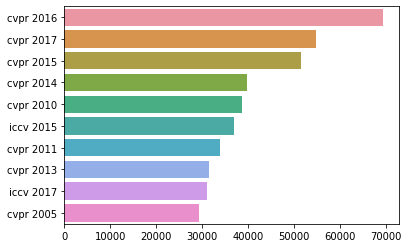

In [13]:
citations_top10 = {v:k for v,k in df_citations_and_locations.groupby(['ConferenceNormalizedName']).CitationCount.sum().sort_values(ascending=False).head(10).items()}

citations_top10_plot = sns.barplot(x=list(citations_top10.values()), y=list(citations_top10.keys()))

#### Flop 10 Conferences Editions by Citation Count

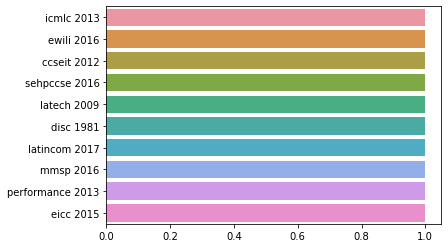

In [14]:
# Only for the conferences with at least a citation
citations_flop10 = {v:k for v,k in df_citations_and_locations[df_citations_and_locations['CitationCount']>0].groupby(['ConferenceNormalizedName']).CitationCount.sum().sort_values().head(10).items()}

citations_flop10_plot = sns.barplot(x=list(citations_flop10.values()), y=list(citations_flop10.keys()))

#### Top 10 Conferences Editions by AVG Citation Count

In [15]:
single_conference_cit = df_citations_and_locations.groupby(['ConferenceNormalizedName']).CitationCount.sum().sort_values(ascending=False)
single_conference_count_article = df_citations_and_locations.groupby(['ConferenceNormalizedName']).CitationCount.count().sort_values(ascending=False)

# AVG Citations Computation
single_conference_avg_cit = {key: (int(val) / int(single_conference_count_article[key])) for key, val in single_conference_cit.items()}

# Dataframe creation
single_conference = {k: [v, single_conference_avg_cit[k], single_conference_count_article[k]] for k, v in single_conference_cit.items()}
df_single_conference = pd.DataFrame(data=single_conference.values(), index=single_conference.keys(), columns=['Total Citations', 'AVG Citations', 'N. of Articles'])
df_single_conference = df_single_conference.sort_values('AVG Citations', ascending=False)

df_single_conference.head(10)

,Total Citations,AVG Citations,N. of Articles
security 2004,1058,1058.000000,1
amia 2009,3792,948.000000,4
wmcsa 1999,5772,481.000000,12
mobicom 2000,13929,480.310345,29
aipr 1994,452,452.000000,1
neurips 1988,1033,344.333333,3
mobicom 2001,9726,324.200000,30
fast 2008,321,321.000000,1
wsna 2002,4641,309.400000,15
sigir 2001,1433,286.600000,5


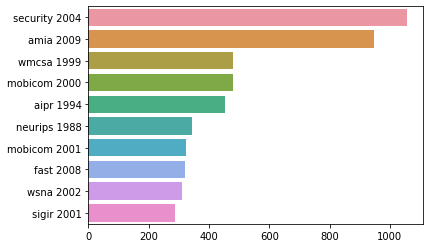

In [16]:
citations_top10_avg = {k:v for k,v in df_single_conference['AVG Citations'].sort_values(ascending=False).head(10).items()}
citations_top10_avg_plot = sns.barplot(x=list(citations_top10_avg.values()), y=list(citations_top10_avg.keys()))

#### Top 10 Considerations
We can notice that the Top 10 Classification by total citations number is different from the Top 10 Classification by the AVG citations. 

It could be interesting to understand the density of the number of articles of each conference.

/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


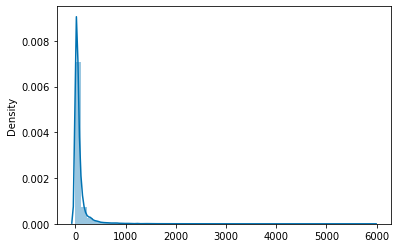

In [17]:
article_by_conference_plot = sns.distplot([v for k,v in single_conference_count_article.items()])
avg_article_by_conference = sum([v for k,v in single_conference_count_article.items()]) / len(single_conference_count_article)

In [18]:
print(f"AVG Articles by conference: {avg_article_by_conference}")

AVG Articles by conference: 85.60002073684939


We can notice that there's a really small number of conferences with a huge number of articles. However, the most of the conferences are in the 10-200 articles range.

### Conferences Evolution Analysis
We're going to study the evolution of a conferences in its editions.

#### AVG Citations of the Conferences
AVG Citation calculated over all the editions of a conference, without considering the year.

In [19]:
conference_tot_cit = df_citations_and_locations.groupby(['ConferenceSeriesNormalizedName']).CitationCount.sum()
conference_tot_article = df_citations_and_locations.groupby(['ConferenceSeriesNormalizedName']).CitationCount.count()
avg_cit_for_conference = {key:(int(val) / int(conference_tot_article[key])) for key, val in conference_tot_cit.items()}

conference = {k: [v, avg_cit_for_conference[k], conference_tot_article[k]] for k, v in conference_tot_cit.items()}
df_conference = pd.DataFrame(data=conference.values(), index=conference.keys(), columns=['Total Citations', 'AVG Citations', 'N. of Articles'])
df_conference = df_conference.sort_values(['AVG Citations'], ascending=False)

df_conference.head(10)

,Total Citations,AVG Citations,N. of Articles
neurips,1033,344.333333,3
wsna,4641,309.400000,15
amia,3861,167.869565,23
mobidata,4202,161.615385,26
avmfss,111,111.000000,1
fosad,487,81.166667,6
hotpower,306,76.500000,4
sna,1267,70.388889,18
caivd,650,65.000000,10
webnet,64,64.000000,1


#### Top 10 Conferences by Citation Count

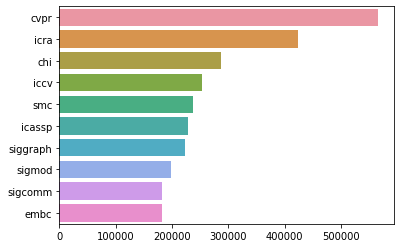

In [20]:
citations_top10_conference_by_cit = {k:v for k,v in df_conference['Total Citations'].sort_values(ascending=False).head(10).items()}
citations_top10_conference_by_cit_plot = sns.barplot(x = list(citations_top10_conference_by_cit.values()), y = list(citations_top10_conference_by_cit.keys()))

#### Top 10 Conferences by AVG Citation Count

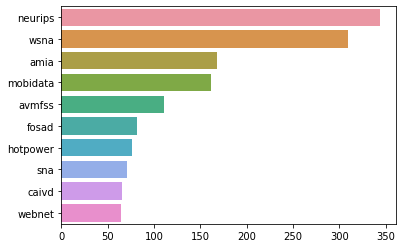

In [21]:
citations_top10_conference_by_avg_cit = {k:v for k,v in df_conference['AVG Citations'].sort_values(ascending=False).head(10).items()}
citations_top10_conference_by_avg_cit_plot = sns.barplot(x = list(citations_top10_conference_by_avg_cit.values()), y = list(citations_top10_conference_by_avg_cit.keys()))

### Study of the Evolution of the Conferences

The study of the evolution of the conferences is one of the most important factors that we need to study for correctly understanding the correlation between the obtained citations and the conference location of a given year.

#### Creation of the Support Structures

**Creation of the dataframe with Total Citations and AVG Citations for each year**

In [22]:
lst_dataframes = []
conference_tot_cit = df_citations_and_locations.groupby(['ConferenceSeriesNormalizedName', 'Year']).CitationCount.sum()
conference_tot_article = df_citations_and_locations.groupby(['ConferenceSeriesNormalizedName', 'Year']).CitationCount.count()
keys = df_citations_and_locations.groupby(['ConferenceSeriesNormalizedName']).CitationCount.count().keys()

for conference in keys:
    single_conference = {}
    tot_cit = 0
    tot_article = 0
    n_editions = 0

    for k, v in conference_tot_cit[conference].items():
        single_conference[str(k) + ' - Total Citations'] = v   # totoal citations for each conference year
        single_conference[str(k) + ' - AVG Citations'] = v / conference_tot_article[conference][k] # avg citations for each conference year
        tot_cit += v #calcolo cit totali
        tot_article += conference_tot_article[conference][k]  # total number of articles for each conference
        n_editions += 1 # number of conference editions for each conference
    single_conference['Total Citations'] = tot_cit
    single_conference['AVG Citations'] = tot_cit / tot_article
    single_conference['N. of Editions'] = n_editions

    # each dataframe contains a conference
    lst_dataframes.append(pd.DataFrame(data = [single_conference.values()], index = [conference], columns = single_conference.keys()))

# creation of the final dataframe
df_conf_evolution = pd.concat(lst_dataframes)

# column and row sort
df_conf_evolution = df_conf_evolution.reindex(sorted(df_conf_evolution.columns), axis=1)
df_conf_evolution = df_conf_evolution.sort_values(['N. of Editions'], ascending=False)

df_conf_evolution

,1981 - AVG Citations,1981 - Total Citations,1982 - AVG Citations,1982 - Total Citations,1983 - AVG Citations,1983 - Total Citations,1984 - AVG Citations,1984 - Total Citations,1985 - AVG Citations,1985 - Total Citations,1986 - AVG Citations,1986 - Total Citations,1987 - AVG Citations,1987 - Total Citations,1988 - AVG Citations,1988 - Total Citations,1989 - AVG Citations,1989 - Total Citations,1990 - AVG Citations,1990 - Total Citations,1991 - AVG Citations,1991 - Total Citations,1992 - AVG Citations,1992 - Total Citations,1993 - AVG Citations,1993 - Total Citations,1994 - AVG Citations,1994 - Total Citations,1995 - AVG Citations,1995 - Total Citations,1996 - AVG Citations,1996 - Total Citations,1997 - AVG Citations,1997 - Total Citations,1998 - AVG Citations,1998 - Total Citations,1999 - AVG Citations,1999 - Total Citations,2000 - AVG Citations,2000 - Total Citations,2001 - AVG Citations,2001 - Total Citations,2002 - AVG Citations,2002 - Total Citations,2003 - AVG Citations,2003 - Total Citations,2004 - AVG Citations,2004 - Total Citations,2005 - AVG Citations,2005 - Total Citations,2006 - AVG Citations,2006 - Total Citations,2007 - AVG Citations,2007 - Total Citations,2008 - AVG Citations,2008 - Total Citations,2009 - AVG Citations,2009 - Total Citations,2010 - AVG Citations,2010 - Total Citations,2011 - AVG Citations,2011 - Total Citations,2012 - AVG Citations,2012 - Total Citations,2013 - AVG Citations,2013 - Total Citations,2014 - AVG Citations,2014 - Total Citations,2015 - AVG Citations,2015 - Total Citations,2016 - AVG Citations,2016 - Total Citations,2017 - AVG Citations,2017 - Total Citations,AVG Citations,N. of Editions,Total Citations
siggraph,7.525424,444.0,16.547170,877.0,15.150943,803.0,17.223684,1309.0,45.471698,4820.0,45.419048,4769.0,51.211268,3636.0,31.005814,5333.0,11.347222,817.0,19.263158,1464.0,23.584615,1533.0,38.684211,2940.0,67.973333,5098.0,41.492188,5311.0,54.297101,7493.0,29.524297,11544.0,18.357422,9399.0,10.991354,7628.0,15.041946,8965.0,73.492958,10436.0,52.626263,10420.0,9.358974,5110.0,7.893281,3994.0,19.379481,15678.0,13.983152,14109.0,10.822807,12338.0,4.816667,4913.0,14.007625,12859.0,11.385517,10691.0,8.036250,6429.0,3.594278,2764.0,1.015385,66.0,12.031288,9998.0,11.458656,8869.0,0.619565,57.0,8.618545,7343.0,4.309446,2646.0,14.341977,37,222903
focs,22.647059,1155.0,49.089552,3289.0,25.883333,1553.0,13.152542,776.0,46.000000,2944.0,51.403509,2930.0,37.236364,2048.0,43.107692,2802.0,26.837398,3301.0,20.532258,3819.0,20.886364,1838.0,14.647541,1787.0,18.092105,1375.0,35.957265,4207.0,28.186667,2114.0,19.867647,1351.0,14.812500,2370.0,17.962500,1437.0,27.454545,2416.0,40.313433,2701.0,5.973333,448.0,38.211765,3248.0,25.905405,1917.0,29.217391,2016.0,21.880000,1641.0,37.712500,3017.0,16.774775,1862.0,23.428571,1968.0,16.676190,1751.0,24.080000,2408.0,21.875000,2275.0,16.642105,1581.0,15.740458,2062.0,9.657343,1381.0,12.262626,1214.0,8.707317,1071.0,9.216495,894.0,22.784784,37,76967
icalp,10.333333,496.0,16.921569,863.0,10.327869,630.0,7.857143,385.0,8.812500,423.0,9.416667,452.0,8.750000,455.0,8.981481,485.0,17.717391,815.0,28.901639,1763.0,12.157143,851.0,16.333333,980.0,6.160714,345.0,6.892857,386.0,6.317460,398.0,10.641791,713.0,10.400000,832.0,12.482353,1061.0,12.084507,858.0,12.912500,1033.0,12.769231,1162.0,16.142857,1582.0,13.572917,1303.0,12.615385,1312.0,20.041379,2906.0,20.038462,2605.0,9.344828,813.0,0.294118,5.0,13.275591,1686.0,1.333333,12.0,8.565891,1105.0,6.890511,944.0,6.104167,879.0,0.785714,11.0,4.727273,780.0,1.000000,1.0,0.333333,47.0,11.044351,37,31377
dac,0.007143,1.0,2.580524,689.0,0.029412,4.0,0.102362,13.0,1.408163,414.0,2.636015,688.0,9.586777,2320.0,1.718894,373.0,8.391447,2551.0,6.369295,1535.0,12.135458,3046.0,3.615385,893.0,12.709898,3724.0,9.200000,2484.0,9.490566,2515.0,6.899614,1787.0,6.462151,1622.0,15.078512,3649.0,8.137536,2840.0,12.051724,4893.0,21.584127,6799.0,5.341346,2222.0,10.964103,4276.0,10.697128,4097.0,9.042105,3436.0,11.976608,6144.0,7.919060,3033.

**Total Citations Dataframe**

Since we need to study the evolution of the conferences, we're going to remove the conferences that only have one edition and without citations.

In [23]:
lst_dataframes = []
for conference in keys:
    single_conference = {}
    n_editions = 0
    for k, v in conference_tot_cit[conference].items():
        single_conference[str(k)] = v 
        n_editions += 1
        
    if n_editions > 1 and df_conf_evolution.loc[conference]['Total Citations'] > 0:
        lst_dataframes.append(pd.DataFrame(data=[single_conference.values()], index = [conference], columns=single_conference.keys()))

df_cit_evolution = pd.concat(lst_dataframes)

df_cit_evolution = df_cit_evolution.reindex(sorted(df_cit_evolution.columns), axis=1)
df_cit_evolution.head(10)

,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
3dic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,959.0,0.0,0.0,NaN,0.0,NaN,NaN,4.0,NaN
3dica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,90.0,60.0,109.0,21.0,84.0,NaN,61.0,NaN,74.0,NaN,56.0,NaN,55.0,173.0,154.0,36.0,7.0,13.0,NaN,NaN
3dim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,2.0
3dimpvt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,574.0,913.0,NaN,NaN,NaN,NaN,NaN
3dor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,4.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0
3dpvt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,954.0,NaN,1047.0,NaN,1590.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3dtv-con,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,576.0,329.0,423.0,359.0,128.0,NaN,148.0,74.0,39.0,44.0
3dui,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137.0,318.0,240.0,290.0,338.0,NaN,352.0,340.0,431.0,243.0,350.0,336.0
3dv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,972.0,543.0,389.0,NaN,687.0
3pgcic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.0,214.0,140.0,NaN,219.0,307.0,80.0,85.0


**AVG Citations Dataframe.**

Since we need to study the evolution of the conferences, we're going to remove the conferences that only have one edition and without citations.

In [24]:
lst_dataframes = []
for conference in keys:
    single_conference = {}
    n_editions = 0
    for k,v in conference_tot_cit[conference].items():
        single_conference[str(k)] = v / conference_tot_article[conference][k] 
        n_editions += 1
    
    if n_editions > 1 and df_conf_evolution.loc[conference]['Total Citations'] > 0:
        lst_dataframes.append(pd.DataFrame(data=[single_conference.values()], index = [conference], columns=single_conference.keys()))

df_avg_cit_evolution = pd.concat(lst_dataframes)

df_avg_cit_evolution = df_avg_cit_evolution.reindex(sorted(df_avg_cit_evolution.columns), axis=1)
df_avg_cit_evolution.head(10)

,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
3dic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.839506,0.000000,0.000000,NaN,0.000000,NaN,NaN,1.333333,NaN
3dica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.473684,4.285714,2.5,3.633333,0.807692,3.652174,NaN,3.388889,NaN,2.176471,NaN,1.647059,NaN,1.774194,3.844444,3.142857,1.161290,0.466667,0.520000,NaN,NaN
3dim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,NaN,NaN,NaN,2.000000
3dimpvt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.629630,12.337838,NaN,NaN,NaN,NaN,NaN
3dor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100000,0.166667,0.250000,0.333333,NaN,NaN,NaN,NaN,0.000000,0.500000
3dpvt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.227273,NaN,3.807273,NaN,11.197183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3dtv-con,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,5.647059,4.569444,6.507692,4.033708,2.245614,NaN,2.551724,2.642857,1.625000,1.419355
3dui,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.892857,12.230769,6.666667,8.055556,9.941176,NaN,7.040000,5.312500,7.836364,4.339286,6.034483,5.014925
3dv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.357143,5.122642,5.256757,NaN,9.410959
3pgcic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.849462,3.194030,2.413793,NaN,2.009174,2.006536,0.860215,1.075949


**Dataframe of the Editions Over and Under the AVG**

First of all, we're going to create two lists for each conference:
* all the years with AVG Citations over the total AVG
* all the years with AVG Citations under the total AVG

In [25]:
dict_over_and_under_avg_cit = {}

for row, col in df_avg_cit_evolution.iterrows():
    list_over_avg = []
    list_under_avg = []

    for k, v in col.items():
        if not math.isnan(v):
            if(v >= df_conference.at[row, 'AVG Citations']):
                list_over_avg.append(k)
            else:
                list_under_avg.append(k)

    tmp_dict = {}
    tmp_dict['Editions Over the AVG'] = list_under_avg
    tmp_dict['Editions Under the AVG'] = list_over_avg

    dict_over_and_under_avg_cit[row] = tmp_dict

Now we're able to compute the percentage of the editions under the average. This is going to allow us to analyze extremes (the conferences with the highest and the lowest percentages); those are the most significant for our purposes.

In [26]:
lst_df = []
for k,v in dict_over_and_under_avg_cit.items():
    v['% Editions Under the AVG'] = (len(v['Editions Under the AVG']) / df_conf_evolution.at[k, 'N. of Editions']) * 100
    lst_df.append(pd.DataFrame(data=[v.values()], index = [k], columns=v.keys()))
      
df_over_and_under_avg_cit = pd.concat(lst_df)
df_over_and_under_avg_cit = df_over_and_under_avg_cit.sort_values(['% Editions Under the AVG'], ascending=False)

df_over_and_under_avg_cit

,Editions Over the AVG,Editions Under the AVG,% Editions Under the AVG
iqec,[],"[1998, 2000]",100.000000
ats,"[2009, 2011, 2012]","[1994, 1995, 1996, 1997, 1999, 2000, 2001, 200...",86.363636
emc,[2016],"[1999, 2005, 2007, 2010, 2013, 2014]",85.714286
rc,[1985],"[2012, 2013, 2014, 2015, 2016, 2017]",85.714286
itherm,[2016],"[1998, 2000, 2002, 2008, 2010]",83.333333
...,...,...,...
mwcn,"[2000, 2004, 2005, 2006, 2007, 2008, 2011, 201...",[2002],7.692308
amia,"[1997, 1998, 2000, 2001, 2002, 2003, 2005, 200...",[2009],7.142857
ctrsa,"[2001, 2003, 2005, 2006, 2007, 2008, 2009, 201...",[2002],7.142857
nime,"[2001, 2002, 2003, 2005, 2006, 2008, 2009, 201...",[2007],6.666667


**Dictionary with the Year and Total Citations of the Year**

It's useful to semplify the creation of the next graphs

In [33]:
dict_cit_conference = {}
for row,col in df_cit_evolution.iterrows():
    x = {}
    for k, v in col.items():
        if not math.isnan(v):
            x[k] = v
    dict_cit_conference[row] = x

**Dictionary with the Year and AVG Citations of the Year**

It's useful to semplify the creation of the next graphs

In [28]:
dict_avg_cit_conference = {}
for row,col in df_avg_cit_evolution.iterrows():
    x = {}
    for k, v in col.items():
        if not math.isnan(v):
            x[k] = v
    dict_avg_cit_conference[row] = x

#### Creation of the Plotting Functions

**Plot of the Total Citations for each Year of a given Conference**

In [29]:
def draw_tot_cit_graph(conf_name):
    plot = sns.barplot(x=list(dict_cit_conference[conf_name].keys()), y=list(dict_cit_conference[conf_name].values()))
    plot.set_xticklabels(plot.get_xticklabels(), rotation=75)
    plot.set_title(conf_name)
    plot.set(xlabel='Year', ylabel='Total Citation Number')
    
    plt.savefig(path_file_export + f'charts/example_tot_{conf_name}.png')

**Plot of the AVG Citations for each Year of a given Conference**

In [30]:
def draw_avg_cit_graph(conf_name):
    plot = sns.barplot(x=list(dict_avg_cit_conference[conf_name].keys()), y=list(dict_avg_cit_conference[conf_name].values()))
    plot.set_xticklabels(plot.get_xticklabels(), rotation=75)
    plot.set_title(conf_name)
    plot.set(xlabel='Year', ylabel='Average Citation Number')
    plot.axhline(df_conference.at[conf_name, 'AVG Citations'], ls='--')
    
    plt.savefig(path_file_export + f'charts/example_avg_{conf_name}.png')

#### Analysis of the Conferences Over and Under the AVG
Now we can study these conferences for understandig why some of them distinguish between the other

In [31]:
top10_num_editions = {k:v for k, v in df_conf_evolution['N. of Editions'].sort_values(ascending=False).head(10).items()}

print('TOP 10 Total Citation: ' + str(list(citations_top10_conference_by_cit.keys())) + "\n")
print('TOP 10 Average Citation: ' + str(list(citations_top10_conference_by_avg_cit.keys())) + "\n")
print('TOP 10 Number of Editions: ' + str(list(top10_num_editions.keys())))

TOP 10 Total Citation: ['cvpr', 'icra', 'chi', 'iccv', 'smc', 'icassp', 'siggraph', 'sigmod', 'sigcomm', 'embc']

TOP 10 Average Citation: ['neurips', 'wsna', 'amia', 'mobidata', 'avmfss', 'fosad', 'hotpower', 'sna', 'caivd', 'webnet']

TOP 10 Number of Editions: ['siggraph', 'isca', 'sigmod', 'stoc', 'sigmetrics', 'focs', 'popl', 'icalp', 'dac', 'sigcse']


**Plot of some of the conferences with the highest Total Citations**

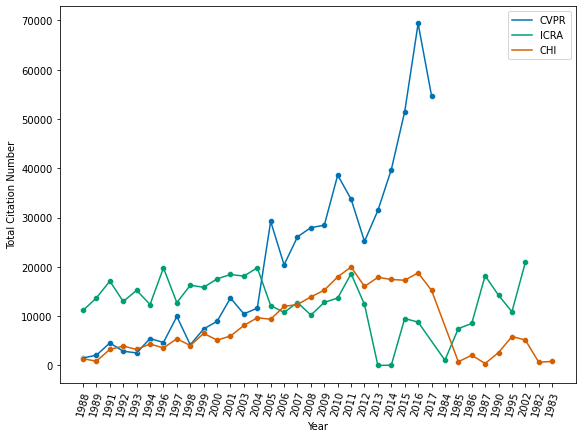

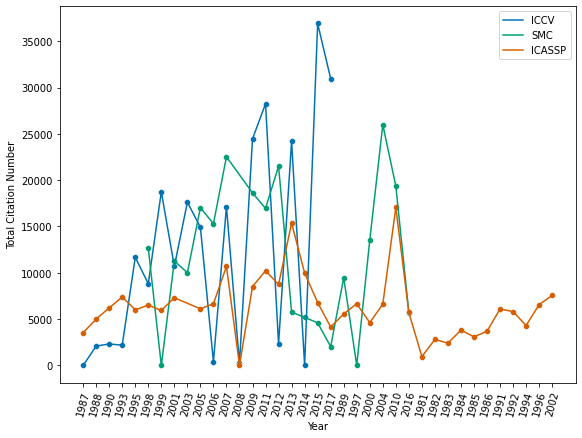

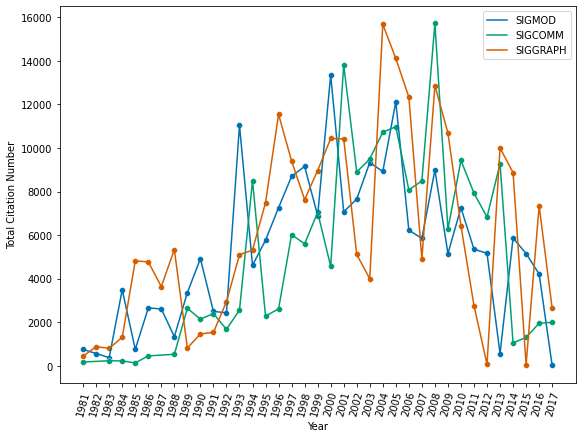

In [34]:
fig,ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=list(dict_cit_conference['cvpr'].keys()), y=list(dict_cit_conference['cvpr'].values()), label='cvpr'.upper())
sns.lineplot(x=list(dict_cit_conference['icra'].keys()), y=list(dict_cit_conference['icra'].values()), label='icra'.upper())
sns.lineplot(x=list(dict_cit_conference['chi'].keys()), y=list(dict_cit_conference['chi'].values()), label='chi'.upper())
sns.scatterplot(x=list(dict_cit_conference['cvpr'].keys()), y=list(dict_cit_conference['cvpr'].values()))
sns.scatterplot(x=list(dict_cit_conference['icra'].keys()), y=list(dict_cit_conference['icra'].values()))
sns.scatterplot(x=list(dict_cit_conference['chi'].keys()), y=list(dict_cit_conference['chi'].values()))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.xticks(rotation=75)
plt.tight_layout()
plt.xlabel("Year")
plt.ylabel("Total Citation Number")
plt.savefig(path_file_export + 'charts/conf_tot_c.png')

fig,ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=list(dict_cit_conference['iccv'].keys()), y=list(dict_cit_conference['iccv'].values()), label='iccv'.upper())
sns.lineplot(x=list(dict_cit_conference['smc'].keys()), y=list(dict_cit_conference['smc'].values()), label='smc'.upper())
sns.lineplot(x=list(dict_cit_conference['icassp'].keys()), y=list(dict_cit_conference['icassp'].values()), label='icassp'.upper())
sns.scatterplot(x=list(dict_cit_conference['iccv'].keys()), y=list(dict_cit_conference['iccv'].values()))
sns.scatterplot(x=list(dict_cit_conference['smc'].keys()), y=list(dict_cit_conference['smc'].values()))
sns.scatterplot(x=list(dict_cit_conference['icassp'].keys()), y=list(dict_cit_conference['icassp'].values()))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.xticks(rotation=75)
plt.tight_layout()
plt.xlabel("Year")
plt.ylabel("Total Citation Number")
plt.savefig(path_file_export + 'charts/conf_tot_b.png')

fig,ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=list(dict_cit_conference['sigmod'].keys()), y=list(dict_cit_conference['sigmod'].values()), label='sigmod'.upper())
sns.lineplot(x=list(dict_cit_conference['sigcomm'].keys()), y=list(dict_cit_conference['sigcomm'].values()), label='sigcomm'.upper())
sns.lineplot(x=list(dict_cit_conference['siggraph'].keys()), y=list(dict_cit_conference['siggraph'].values()), label='siggraph'.upper())
sns.scatterplot(x=list(dict_cit_conference['sigmod'].keys()), y=list(dict_cit_conference['sigmod'].values()))
sns.scatterplot(x=list(dict_cit_conference['sigcomm'].keys()), y=list(dict_cit_conference['sigcomm'].values()))
sns.scatterplot(x=list(dict_cit_conference['siggraph'].keys()), y=list(dict_cit_conference['siggraph'].values()))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.xticks(rotation=75)
plt.tight_layout()
plt.xlabel("Year")
plt.ylabel("Total Citation Number")
plt.savefig(path_file_export + 'charts/conf_tot_a.png')

**Plot of the AVG Citations with the Conferences with the highest Citations**

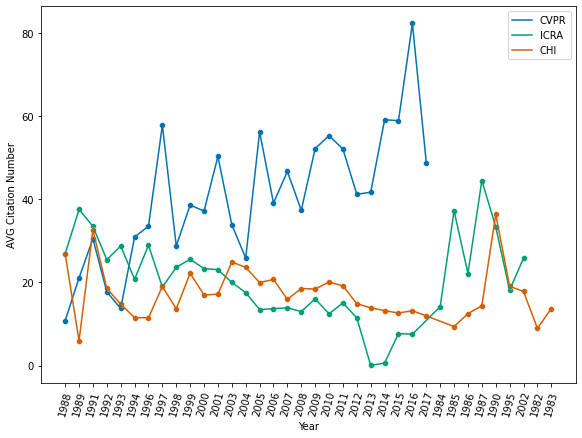

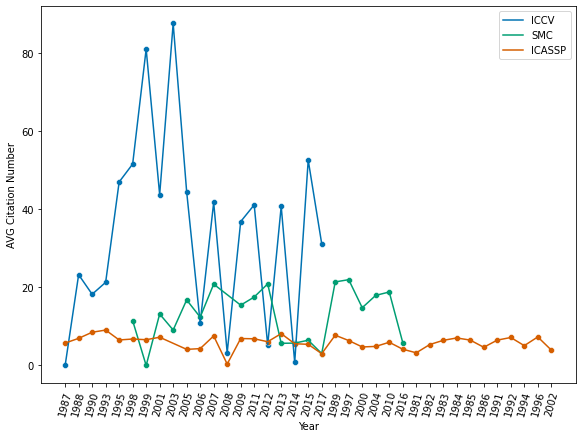

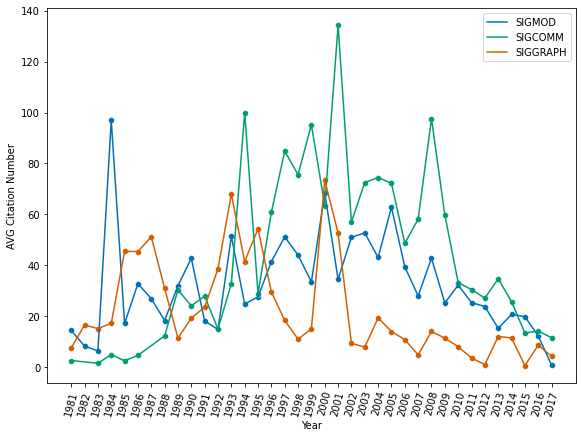

In [35]:
fig,ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=list(dict_avg_cit_conference['cvpr'].keys()), y=list(dict_avg_cit_conference['cvpr'].values()), label='cvpr'.upper())
sns.lineplot(x=list(dict_avg_cit_conference['icra'].keys()), y=list(dict_avg_cit_conference['icra'].values()), label='icra'.upper())
sns.lineplot(x=list(dict_avg_cit_conference['chi'].keys()), y=list(dict_avg_cit_conference['chi'].values()), label='chi'.upper())
sns.scatterplot(x=list(dict_avg_cit_conference['cvpr'].keys()), y=list(dict_avg_cit_conference['cvpr'].values()))
sns.scatterplot(x=list(dict_avg_cit_conference['icra'].keys()), y=list(dict_avg_cit_conference['icra'].values()))
sns.scatterplot(x=list(dict_avg_cit_conference['chi'].keys()), y=list(dict_avg_cit_conference['chi'].values()))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.xticks(rotation=75)
plt.tight_layout()
plt.xlabel("Year")
plt.ylabel("AVG Citation Number")
plt.savefig(path_file_export + 'charts/conf_tot_avg_c.png')

fig,ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=list(dict_avg_cit_conference['iccv'].keys()), y=list(dict_avg_cit_conference['iccv'].values()), label='iccv'.upper())
sns.lineplot(x=list(dict_avg_cit_conference['smc'].keys()), y=list(dict_avg_cit_conference['smc'].values()), label='smc'.upper())
sns.lineplot(x=list(dict_avg_cit_conference['icassp'].keys()), y=list(dict_avg_cit_conference['icassp'].values()), label='icassp'.upper())
sns.scatterplot(x=list(dict_avg_cit_conference['iccv'].keys()), y=list(dict_avg_cit_conference['iccv'].values()))
sns.scatterplot(x=list(dict_avg_cit_conference['smc'].keys()), y=list(dict_avg_cit_conference['smc'].values()))
sns.scatterplot(x=list(dict_avg_cit_conference['icassp'].keys()), y=list(dict_avg_cit_conference['icassp'].values()))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.xticks(rotation=75)
plt.tight_layout()
plt.xlabel("Year")
plt.ylabel("AVG Citation Number")
plt.savefig(path_file_export + 'charts/conf_tot_avg_b.png')

fig,ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=list(dict_avg_cit_conference['sigmod'].keys()), y=list(dict_avg_cit_conference['sigmod'].values()), label='sigmod'.upper())
sns.lineplot(x=list(dict_avg_cit_conference['sigcomm'].keys()), y=list(dict_avg_cit_conference['sigcomm'].values()), label='sigcomm'.upper())
sns.lineplot(x=list(dict_avg_cit_conference['siggraph'].keys()), y=list(dict_avg_cit_conference['siggraph'].values()), label='siggraph'.upper())
sns.scatterplot(x=list(dict_avg_cit_conference['sigmod'].keys()), y=list(dict_avg_cit_conference['sigmod'].values()))
sns.scatterplot(x=list(dict_avg_cit_conference['sigcomm'].keys()), y=list(dict_avg_cit_conference['sigcomm'].values()))
sns.scatterplot(x=list(dict_avg_cit_conference['siggraph'].keys()), y=list(dict_avg_cit_conference['siggraph'].values()))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.xticks(rotation=75)
plt.tight_layout()
plt.xlabel("Year")
plt.ylabel("AVG Citation Number")
plt.savefig(path_file_export + 'charts/conf_tot_avg_a.png')

**Plot of some of the conferences with the highest AVG Citations**

**Note**: since some of the conferences in our top 10 only have one edition, we're going to compute a new top 10 for only the conferences that have at least a specified number of editions.

In [36]:
minimum_number_of_editions = 5

TOP 10 Average Citation: ['amia', 'mobicom', 'sosp', 'security', 'eurocrypt', 'crypto', 'cvpr', 'sigcomm', 'iccv', 'sasn']



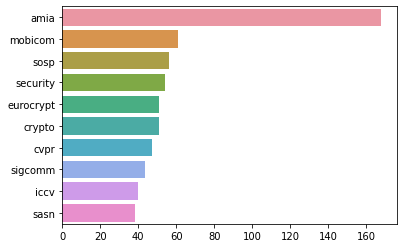

In [37]:
# df with the conferences that have at least five editions
conf_with_at_least_five_editions = list()

for index, row in df_conf_evolution.iterrows():
    if(row['N. of Editions'] >= minimum_number_of_editions):
        conf_with_at_least_five_editions.append(index)

df_conference_with_more_editions = df_conference.loc[conf_with_at_least_five_editions]

citations_top10_conference_with_more_editions_by_avg_cit = {k:v for k,v in df_conference_with_more_editions['AVG Citations'].sort_values(ascending=False).head(10).items()}

sns.barplot(x = list(citations_top10_conference_with_more_editions_by_avg_cit.values()), y = list(citations_top10_conference_with_more_editions_by_avg_cit.keys()))
print('TOP 10 Average Citation: ' + str(list(citations_top10_conference_with_more_editions_by_avg_cit.keys())) + "\n")

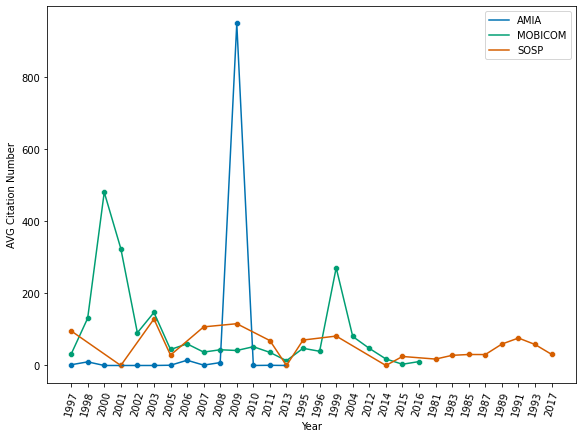

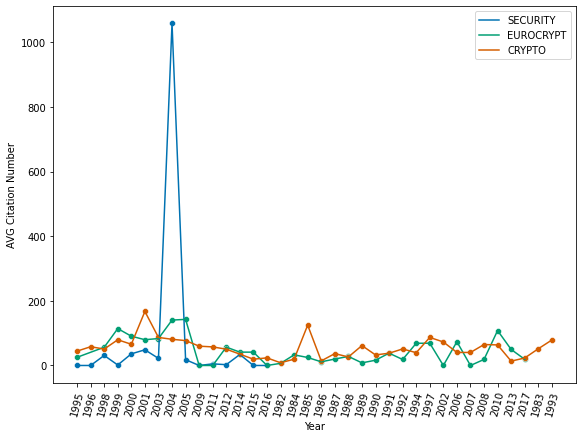

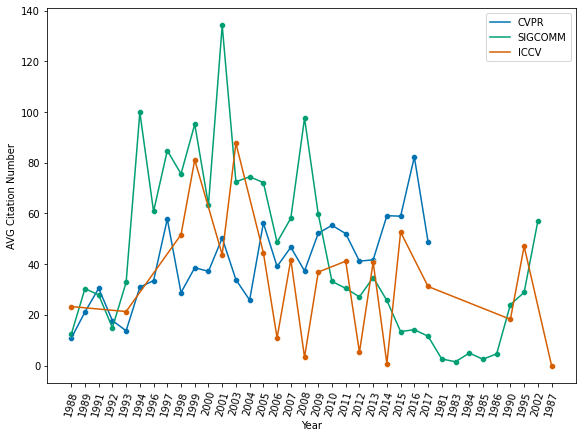

In [38]:
fig,ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=list(dict_avg_cit_conference['amia'].keys()), y=list(dict_avg_cit_conference['amia'].values()), label='amia'.upper())
sns.lineplot(x=list(dict_avg_cit_conference['mobicom'].keys()), y=list(dict_avg_cit_conference['mobicom'].values()), label='mobicom'.upper())
sns.lineplot(x=list(dict_avg_cit_conference['sosp'].keys()), y=list(dict_avg_cit_conference['sosp'].values()), label='sosp'.upper())
sns.scatterplot(x=list(dict_avg_cit_conference['amia'].keys()), y=list(dict_avg_cit_conference['amia'].values()))
sns.scatterplot(x=list(dict_avg_cit_conference['mobicom'].keys()), y=list(dict_avg_cit_conference['mobicom'].values()))
sns.scatterplot(x=list(dict_avg_cit_conference['sosp'].keys()), y=list(dict_avg_cit_conference['sosp'].values()))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.xticks(rotation=75)
plt.tight_layout()
plt.xlabel("Year")
plt.ylabel("AVG Citation Number")
plt.savefig(path_file_export + 'charts/conf_avg_c.png')

fig,ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=list(dict_avg_cit_conference['security'].keys()), y=list(dict_avg_cit_conference['security'].values()), label='security'.upper())
sns.lineplot(x=list(dict_avg_cit_conference['eurocrypt'].keys()), y=list(dict_avg_cit_conference['eurocrypt'].values()), label='eurocrypt'.upper())
sns.lineplot(x=list(dict_avg_cit_conference['crypto'].keys()), y=list(dict_avg_cit_conference['crypto'].values()), label='crypto'.upper())
sns.scatterplot(x=list(dict_avg_cit_conference['security'].keys()), y=list(dict_avg_cit_conference['security'].values()))
sns.scatterplot(x=list(dict_avg_cit_conference['eurocrypt'].keys()), y=list(dict_avg_cit_conference['eurocrypt'].values()))
sns.scatterplot(x=list(dict_avg_cit_conference['crypto'].keys()), y=list(dict_avg_cit_conference['crypto'].values()))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.xticks(rotation=75)
plt.tight_layout()
plt.xlabel("Year")
plt.ylabel("AVG Citation Number")
plt.savefig(path_file_export + 'charts/conf_avg_b.png')

fig,ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=list(dict_avg_cit_conference['cvpr'].keys()), y=list(dict_avg_cit_conference['cvpr'].values()), label='cvpr'.upper())
sns.lineplot(x=list(dict_avg_cit_conference['sigcomm'].keys()), y=list(dict_avg_cit_conference['sigcomm'].values()), label='sigcomm'.upper())
sns.lineplot(x=list(dict_avg_cit_conference['iccv'].keys()), y=list(dict_avg_cit_conference['iccv'].values()), label='iccv'.upper())
sns.scatterplot(x=list(dict_avg_cit_conference['cvpr'].keys()), y=list(dict_avg_cit_conference['cvpr'].values()))
sns.scatterplot(x=list(dict_avg_cit_conference['sigcomm'].keys()), y=list(dict_avg_cit_conference['sigcomm'].values()))
sns.scatterplot(x=list(dict_avg_cit_conference['iccv'].keys()), y=list(dict_avg_cit_conference['iccv'].values()))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
plt.xticks(rotation=75)
plt.tight_layout()
plt.xlabel("Year")
plt.ylabel("AVG Citation Number")
plt.savefig(path_file_export + 'charts/conf_avg_a.png')

**Single Plots for Total Citation Number**

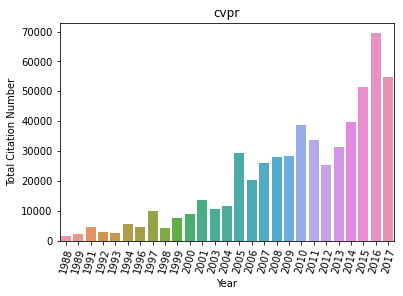

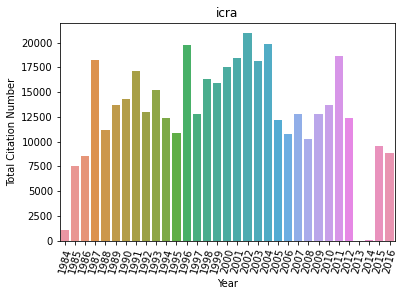

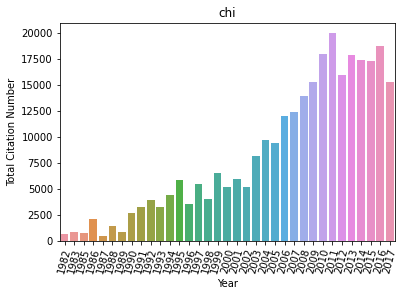

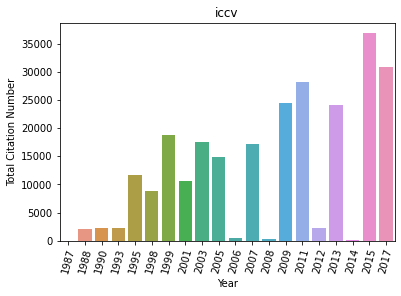

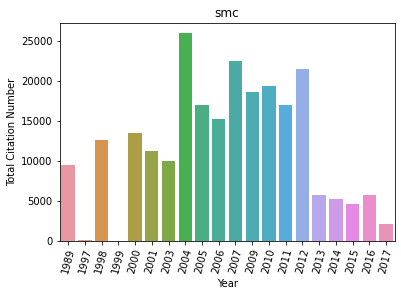

In [39]:
for key in list(citations_top10_conference_by_cit.keys())[0:5]:
    plt.figure(key)
    draw_tot_cit_graph(key)

**Single Plots for AVG Citation Number**

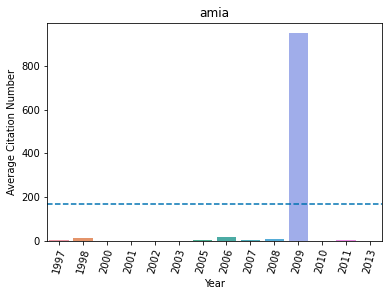

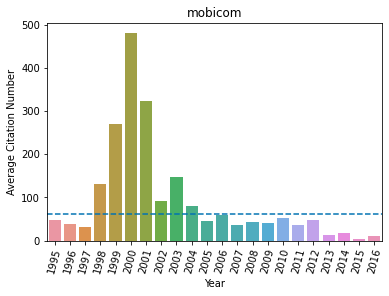

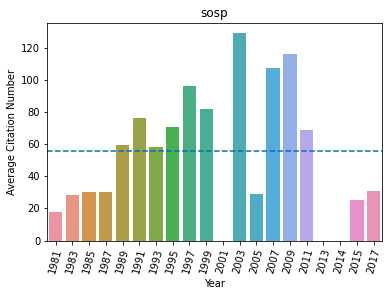

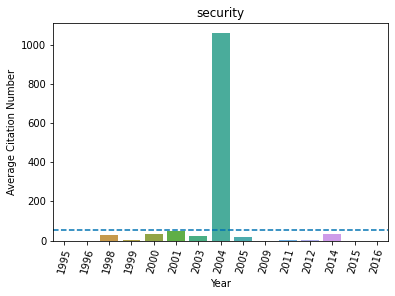

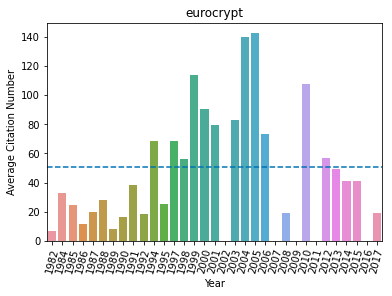

In [40]:
for key in list(citations_top10_conference_with_more_editions_by_avg_cit.keys())[0:5]:
    plt.figure(key)
    draw_avg_cit_graph(key)

**Single Plots for Conferences with a High Percentage of Editions Under the AVG**

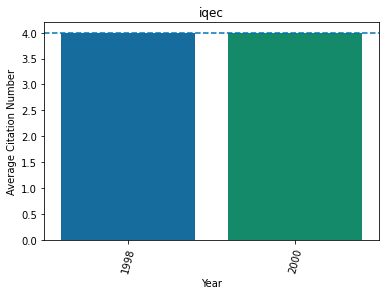

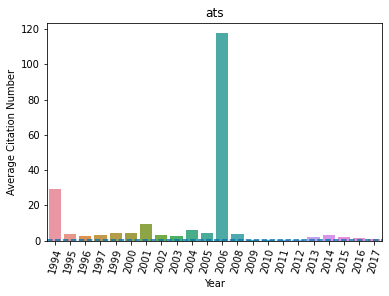

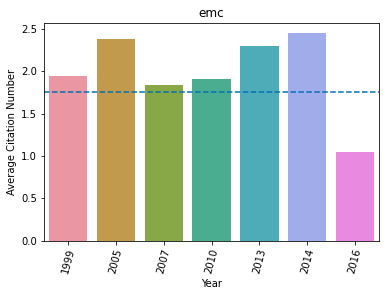

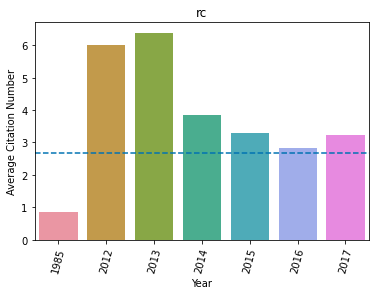

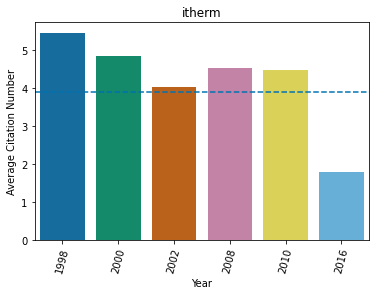

In [42]:
for row,col in list(df_over_and_under_avg_cit.iterrows())[0:5]:
    plt.figure(row)
    draw_avg_cit_graph(row)

#### Some Interesting Observations
We can already make some observations looking at these graphs.

We can easily notice that usually there are **huge differences between the different editions of a conferences**. This datum is really interesting since it will help us choice which year and conferences to consider for our analysis.

Another interesting datum is that some conferences have a really huge Total AVG Citation number, but **the AVG Citation is high only for a single year**. Maybe that was a pretty profitable year, or maybe it's simply an abnormal year for which we haven't enough data (example: a single article with a lot of citations could cause the AVG value to reach that level).
**These conferences could be a problem for our analysis**. We have to keep an eye on them.